In [1]:
#  Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

C:\Users\camar\AppData\Local\Temp\ipykernel_968\3560610281.py:19: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_968\3560610281.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_968\3560610281.py:26: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)


In [4]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [5]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [6]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [7]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [8]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [9]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [10]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [11]:
# TODO -> AFTER GAM FILE CONVERSION

def runSolver(file, loadLimit, genLimit, genInfo, gen, Load, period, stor, storLimit, storInfo,
              pMaxImp, pMaxExp, buyPrice, sellPrice, v2gLimit, v2gInfo, v2g,
              cs, cslimit, csInfo, EV_CS_Info):
    
    
    temp_output = [resFun, resCost, resSelf, statusOptPro, 
                   resPImp, resPExp, resGenAct, resGenExcAct,resGenX, 
                   resLoadRed, resLoadCut, 
                   resLoadENS, resLoadX, resLoad, resStorEnerState, resStorChActPower, resStorDchActPower,
                   resv2gEnerState, resv2gDchActPower, resv2gChActPower, resv2gRelax, resCsPower]
    
    return temp_output

In [12]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process
#set genLimitInfo 'Indicate the number of columns of information from generators'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set loadLimitInfo 'Indicate the number of columns of information from loads'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set storLimitInfo 'Indicate the number of columns of information from storage units'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set v2gLimitInfo 'Indicate the number of columns of information from electric vehicles'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

#set csLimitInfo 'Indicate the number of columns of information from charging stations'
#/1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12/;

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

#genLimitInfo = np.arange(1, genLimit.shape[2]+1)
#loadLimitInfo = np.arange(1, loadLimit.shape[2]+1)
#storLimitInfo = np.arange(1, storLimit.shape[2]+1)
#v2gLimitInfo = np.arange(1, v2gLimit.shape[2]+1)
#csLimitInfo = np.arange(1, csLimit.shape[0]+1)

In [13]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(1, period+1)
_gen = np.arange(1, gen+1)
_Load = np.arange(1, Load+1)
_stor = np.arange(1, stor+1)
_v2g = np.arange(1, v2g+1)
_cs = np.arange(1, cs+1)

In [14]:
# Aux function to convert numpy into dictionaries

def _auxDictionary(a):
    temp_dictionary = {}
    
    if len(a.shape) == 3:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                for dim2 in np.arange(a.shape[2]):
                    temp_dictionary[(dim0+1, dim1+1, dim2+1)] = a[dim0, dim1, dim2]
    elif len(a.shape) == 2:
        for dim0 in np.arange(a.shape[0]):
            for dim1 in np.arange(a.shape[1]):
                temp_dictionary[(dim0+1, dim1+1)] = a[dim0, dim1]
                
    else:
        for dim0 in np.arange(a.shape[0]):
            temp_dictionary[(dim0+1)] = a[dim0]
                
    return temp_dictionary

#temp_dict1 = _auxDictionary(loadLimit)

In [15]:
# Pyomo imports

import pyomo
import pyomo.opt
import pyomo.environ as pe

In [16]:
# Model creation

model = pe.ConcreteModel()

model.genLimitInfo = pe.Set(initialize=genLimitInfo, 
                            doc='Indicate the number of columns of information from generators')
model.loadLimitInfo = pe.Set(initialize=loadLimitInfo, 
                             doc='Indicate the number of columns of information from loads')
model.storLimitInfo = pe.Set(initialize=storLimitInfo, 
                             doc='Indicate the number of columns of information from storage units')
model.v2gLimitInfo = pe.Set(initialize=v2gLimitInfo, 
                            doc='Indicate the number of columns of information from electric vehicles')
model.csLimitInfo = pe.Set(initialize=csLimitInfo, 
                           doc='Indicate the number of columns of information from charging stations')

# Sets
model.t = pe.Set(initialize=_t, doc='period')
model.gen = pe.Set(initialize=_gen, doc='generators')
model.loads = pe.Set(initialize=_Load, doc='loads')
model.stor = pe.Set(initialize=_stor, doc='storage')
model.v2g = pe.Set(initialize=_v2g, doc='vehicles')
model.cs = pe.Set(initialize=_cs, doc='charging_stations')

In [17]:
# Define the parameters with the data from the excel, such as limits, price, and voltage

model.loadLimit = pe.Param(model.loads, model.t, model.loadLimitInfo, 
                           initialize=_auxDictionary(loadLimit))

model.genLimit = pe.Param(model.gen, model.t, model.genLimitInfo,
                          initialize=_auxDictionary(genLimit))

model.genInfo = pe.Param(model.gen, model.genLimitInfo,
                         initialize=_auxDictionary(genInfo))

model.pMaxImp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxImp))

model.buyPrice = pe.Param(model.t,
                          initialize=_auxDictionary(buyPrice))

model.pMaxExp = pe.Param(model.t,
                         initialize=_auxDictionary(pMaxExp))

model.sellPrice = pe.Param(model.t,
                           initialize=_auxDictionary(sellPrice))

model.storLimit = pe.Param(model.stor, model.t, model.storLimitInfo,
                           initialize=_auxDictionary(storLimit))

model.storInfo = pe.Param(model.stor, model.storLimitInfo,
                          initialize=_auxDictionary(storInfo[:, :12]))

model.v2gLimit = pe.Param(model.v2g, model.t, model.v2gLimitInfo,
                          initialize=_auxDictionary(v2gLimit))

model.v2gInfo = pe.Param(model.v2g, model.v2gLimitInfo,
                         initialize=_auxDictionary(v2gInfo))

model.csLimit = pe.Param(model.cs, model.t, model.csLimitInfo,
                         initialize=_auxDictionary(csLimit))

model.csInfo = pe.Param(model.cs, model.csLimitInfo,
                        initialize=_auxDictionary(csInfo))

model.EV_CS_Info = pe.Param(model.v2g, model.cs, model.t,
                            initialize=_auxDictionary(EV_CS_Info))

model.loadActPower = pe.Param(model.loads, model.t,
                              initialize=_auxDictionary(loadLimit[:, :, 0]))
model.optCost = pe.Var()#initialize=0)

In [18]:
# Define the variables for the gams optimization process
# variables fun, derCost, selfConso;

#model.fun = pe.Var(domain=pe.Reals, initialize=0)
model.derCost = pe.Var(domain=pe.Reals, initialize=0)
#model.selfConso = pe.Var(domain=pe.Reals, initialize=0)

In [19]:
#positive variables

model.genActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.genExcActPower = pe.Var(model.gen, model.t, domain=pe.PositiveReals, initialize=1)
model.pImp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)
model.pExp = pe.Var(model.t, domain=pe.PositiveReals, initialize=1)

In [20]:
# Load params
model.loadRedActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadCutActPower = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)
model.loadENS = pe.Var(model.loads, model.t, domain=pe.PositiveReals, initialize=1)

# Storage params
model.storEnerState = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storDchActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.storChActPower = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)
model.EminRelaxStor = pe.Var(model.stor, model.t, domain=pe.PositiveReals, initialize=1)

# V2G params
model.v2gDchActPower = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.v2gChActPower = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.v2gEnerState = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)
model.EminRelaxEv = pe.Var(model.v2g, model.t, domain=pe.PositiveReals, initialize=1)

# Charging Station params
model.csActPower = pe.Var(model.cs, model.t, domain=pe.PositiveReals, initialize=1)
model.csActPowerNet = pe.Var(model.cs, model.t, domain=pe.PositiveReals, initialize=1)

In [21]:
# binary variables

model.genXo = pe.Var(model.gen, model.t, domain=pe.Binary, initialize=0)
model.loadXo = pe.Var(model.loads, model.t, domain=pe.Binary, initialize=0)

In [22]:
model.v2gChXo = pe.Var(model.v2g, model.t, domain=pe.Binary, initialize=0)
model.v2gDchXo = pe.Var(model.v2g, model.t, domain=pe.Binary, initialize=0)
model.storChXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)
model.storDchXo = pe.Var(model.stor, model.t, domain=pe.Binary, initialize=0)

In [23]:
# Default behaviour

default_behaviour = pe.Constraint.Skip

In [24]:
# Network constraints

def _maxImpEq(m, t):
    return m.pImp[t] <= m.pMaxImp[t] 

model.MaxImpEq = pe.Constraint(model.t, rule=_maxImpEq)

def _maxExpEq(m, t):
    return m.pExp[t] <= m.pMaxExp[t]

model.MaxExpEq = pe.Constraint(model.t, rule=_maxExpEq)

In [25]:
# Generator constraints with the active generation power

# Maximum generation in generators with normal contract
def _genActMaxEq1(m, g, t):
    if m.genInfo[g, 5] != 1:
        return (m.genActPower[g, t] <= m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq1 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq1)

#*Minimum generation in generators with normal contract
def _genActMinEq(m, g, t):
    if m.genInfo[g, 5] != 1:
        return (m.genActPower[g, t] >= m.genInfo[g, 7] * m.genXo[g, t])
    return default_behaviour
    
model.genActMinEq = pe.Constraint(model.gen, model.t, rule=_genActMinEq)

#*Generation in generators with Feed-in tariffs
def _genActMaxEq2(m, g, t):
    if m.genInfo[g, 5] != 2:
        return (m.genActPower[g ,t] + m.genExcActPower[g, t] == m.genLimit[g, t, 1])
    return default_behaviour
    
model.genActMaxEq2 = pe.Constraint(model.gen, model.t, rule=_genActMaxEq2)

In [26]:
# Load constraints

def _loadReactEq(m, l, t):
    return m.loadRedActPower[l, t] <= m.loadLimit[l, t, 3]

model.loadReactEq = pe.Constraint(model.loads, model.t, rule=_loadReactEq)


def _loadCutActPowerEq(m, l, t):
    return m.loadCutActPower[l, t] == m.loadLimit[l, t, 4] * m.loadXo[l, t]

model.loadCutActPowerEq = pe.Constraint(model.loads, model.t, rule=_loadCutActPowerEq)


def _loadENSEq(m, l, t):
    return m.loadENS[l, t] + m.loadRedActPower[l, t] + m.loadCutActPower[l, t] <= m.loadActPower[l, t]

model.loadENSEq = pe.Constraint(model.loads, model.t, rule=_loadENSEq)

In [27]:
# Storage constraints

def _storDchRateIneq(m, s, t):
    return m.storDchActPower[s, t] <= m.storLimit[s, t, 2] * m.storDchXo[s, t]
model.storDchRateIneq = pe.Constraint(model.stor, model.t, rule=_storDchRateIneq)


def _storChRateIneq(m, s, t):
    return m.storChActPower[s, t] <= m.storLimit[s, t, 1] * m.storChXo[s, t]
model.storChRateIneq = pe.Constraint(model.stor, model.t, rule=_storChRateIneq)


def _storMaxEq(m, s, t):
    return m.storEnerState[s, t] <= m.storInfo[s, 6]
model.storMaxEq = pe.Constraint(model.stor, model.t, rule=_storMaxEq)


def _storRelaxEq(m, s, t):
    return m.storEnerState[s, t] >= m.storInfo[s, 7] * m.storInfo[s, 6]/100 - m.EminRelaxStor[s, t]
model.storRelaxEq = pe.Constraint(model.stor, model.t, rule=_storRelaxEq)


def _storBatBalanceEq(m, s, t):
    if t == 1:
        return m.storEnerState[s, t] == m.storInfo[s, 6] * m.storInfo[s, 10]/100 + m.storChActPower[s, t] * m.storInfo[s, 8]/100 - m.storDchActPower[s, t]/m.storInfo[s, 9] / 100
    elif t > 1:
        return m.storEnerState[s, t] == m.storEnerState[s, t-1] + m.storChActPower[s, t] * m.storInfo[s, 8]/100 - m.storDchActPower[s, t]/m.storInfo[s, 9]/100
    return default_behaviour
model.storBatBalance = pe.Constraint(model.stor, model.t, rule=_storBatBalanceEq)


def _storBin(m, s, t):
    return m.storChXo[s, t] + m.storDchXo[s, t] <= 1
model.storBin = pe.Constraint(model.stor, model.t, rule=_storBin)

C:\Users\camar\AppData\Local\Temp\ipykernel_968\2279289384.py:19: RuntimeWarning: overflow encountered in ubyte_scalars
  return m.storEnerState[s, t] >= m.storInfo[s, 7] * m.storInfo[s, 6]/100 - m.EminRelaxStor[s, t]
C:\Users\camar\AppData\Local\Temp\ipykernel_968\2279289384.py:25: RuntimeWarning: overflow encountered in ubyte_scalars
  return m.storEnerState[s, t] == m.storInfo[s, 6] * m.storInfo[s, 10]/100 + m.storChActPower[s, t] * m.storInfo[s, 8]/100 - m.storDchActPower[s, t]/m.storInfo[s, 9] / 100


In [28]:
# Electric Vehicles constraints

# Discharge rate
def _v2gDchRateIneq(m, v, t):
    return m.v2gDchActPower[v, t] <= m.v2gLimit[v, t, 5] * m.v2gLimit[v, t, 1] * m.v2gDchXo[v, t]
model.v2gDchRateIneq = pe.Constraint(model.v2g, model.t, rule=_v2gDchRateIneq)

# Charge rate
def _v2gChRateIneq(m, v, t):
    return m.v2gChActPower[v, t] <= m.v2gLimit[v, t, 4] * m.v2gLimit[v, t, 1] * m.v2gChXo[v, t]
model.v2gChRateIneq = pe.Constraint(model.v2g, model.t, rule=_v2gChRateIneq)

# Energy Limits
def _v2gMaxEq(m, v, t):
    return m.v2gEnerState[v, t] <= m.v2gInfo[v, 5]
model.v2gMaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gMaxEq)

def _v2gRelaxEq(m, v, t):
    if m.v2gLimit[v, t, 1] == 1:
        return m.v2gEnerState[v, t] >= m.v2gInfo[v, 11] * m.v2gInfo[v, 5]/100 - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxEq = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxEq)


# Energy Limits - If requirement
def _v2gRelaxReqEq1(m, v, t):
    if m.v2gLimit[v, t, 1] == 1:
        return m.v2gEnerState[v, t] >= m.v2gLimit[v, t, 3] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq1 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq1)


def _v2gRelaxReqEq2(m, v, t):
    if t < m.t.last():
        if (m.v2gLimit[v, t, 1] == 1) & (m.v2gLimit[v, t+1, 1] == 0) & (m.v2gLimit[v, t, 3] == 0):
            return m.v2gEnerState[v, t] >= m.v2gInfo[v, 5] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq2 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq2)


def _v2gRelaxReqEq3(m, v, t):
    if (m.v2gLimit[v, t, 1] == 1) & (m.v2gLimit[v, t, 3] == 0) & (t == m.t.last()):
        return m.v2gEnerState[v, t] >= m.v2gInfo[v, 5] - m.EminRelaxEv[v, t]
    return default_behaviour
model.v2gRelaxReqEq3 = pe.Constraint(model.v2g, model.t, rule=_v2gRelaxReqEq3)


#Energy balance
def _v2gBatBalanceZero(m, v, t):
    if m.v2gLimit[v, t, 1] == 0:
        return m.v2gEnerState[v, t] == 0
    return default_behaviour
model.v2gBatBalanceZero = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceZero)


def _v2gBatBalanceIniEq(m, v, t):
    if (m.v2gLimit[v, t, 1] == 1) & (t == 1):
        return m.v2gEnerState[v, t] == m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] - m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceIniEq = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceIniEq)


def _v2gBatBalanceEq(m, v, t):
    if t > 1:
        if (m.v2gLimit[v, t-1, 1] == 1) & (m.v2gLimit[v, t, 1] == 1):
            return m.v2gEnerState[v, t] == m.v2gEnerState[v, t-1] + m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] - m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceEq = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceEq)


def _v2gBatBalanceEq2(m, v, t):
    if t > 1:
        if (m.v2gLimit[v, t-1, 1] == 0) & (m.v2gLimit[v, t, 1] == 1):
            return m.v2gEnerState[v, t] == m.v2gLimit[v, t, 2] + m.v2gChActPower[v, t] * m.v2gInfo[v, 8] + m.v2gDchActPower[v, t] / m.v2gInfo[v, 9]
    return default_behaviour
model.v2gBatBalanceEq2 = pe.Constraint(model.v2g, model.t, rule=_v2gBatBalanceEq2)


# disable charge and discharge in same period
def _v2gBin(m, v, t):
    return m.v2gChXo[v, t] + m.v2gDchXo[v, t] <= 1
model.v2gBin = pe.Constraint(model.v2g, model.t, rule=_v2gBin)

In [29]:
# Charging Station constraints

# Charge Limits

def _csActMaxEq(m, c, t):
    return m.csActPower[c, t] <= m.csInfo[c, 5]
model.csActMaxEq = pe.Constraint(model.cs, model.t, rule=_csActMaxEq)


def _csActMinEq(m, c, t):
    return m.csActPower[c, t] >= -m.csInfo[c,  6]
model.csActMinEq = pe.Constraint(model.cs, model.t, rule=_csActMinEq)


def _csActPowerEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.EV_CS_Info[v, c, t] > 0:
            temp_val.append(m.v2gChActPower[v, t] - m.v2gDchActPower[v, t])
    
    return m.csActPower[c, t] == sum(temp_val)
model.csActPowerEq = pe.Constraint(model.cs, model.t, rule=_csActPowerEq)


def _csActPowerNetEq(m, c, t):
    temp_val = []
    for v in np.arange(1, m.v2g.last() + 1):
        if m.EV_CS_Info[v, c, t] > 0:
            temp_val.append(m.v2gChActPower[v, t] / (m.csInfo[c, 7] / 100) - m.v2gDchActPower[v, t] * m.csInfo[c, 8] / 100)
        
    return m.csActPowerNet[c, t] == sum(temp_val)
model.csActPowerNetEq = pe.Constraint(model.cs, model.t, rule=_csActPowerNetEq)

In [30]:
# Energy Balance

def _actBalanceEqSimple(m, t):
    temp_sum1 = sum([m.genActPower[i, t] - m.genExcActPower[i, t] for i in np.arange(1, m.gen.last()+1)])
    temp_sum2 = sum(m.loadActPower[:, t])
    
    return temp_sum1 + m.pImp[t] - m.pExp[t] - temp_sum2 == 0

#model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEqSimple)


def _actBalanceEq(m, t):
    temp_gens = sum([m.genActPower[g, t] - m.genExcActPower[g, t] for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadActPower[l, t] - m.loadRedActPower[l, t] - m.loadCutActPower[l, t] - m.loadENS[l, t]
                      for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storChActPower[s, t] - m.storDchActPower[s, t]
                     for s in np.arange(1, m.stor.last() + 1)])
    
    temp_v2g = sum([m.v2gChActPower[v, t] - m.v2gDchActPower[v, t]
                    for v in np.arange(1, m.v2g.last() + 1)])
    temp_cs = sum(m.csActPowerNet[:, t])
    
    return temp_gens + m.pImp[t] - m.pExp[t] - temp_loads - temp_stor - temp_v2g - temp_cs == 0
model.actBalanceSimple = pe.Constraint(model.t, rule=_actBalanceEq)

In [31]:
# Objective Function -> Only considering generators

def _objFunSimple(m):
    temp_sum1 = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last()+1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_sum2 = sum([m.pImp[i] * m.buyPrice[i] - m.pExp[i] * m.sellPrice[i] for i in np.arange(1, m.t.last()+1)])
    m.derCost = temp_sum1 + temp_sum2

    return temp_sum1 + temp_sum2

#model.ObjFunSimple = pe.Objective(rule=_objFunSimple, sense=pe.minimize)


def _objFun(m):
    temp_gens = sum([m.genActPower[g, t] * m.genLimit[g, t, 3] + m.genExcActPower[g, t] * m.genLimit[g, t, 5]
                     for t in np.arange(1, m.t.last() + 1) for g in np.arange(1, m.gen.last()+1)])
    
    temp_loads = sum([m.loadRedActPower[l, t] * m.loadLimit[l, t, 7] + m.loadCutActPower[l, t] * m.loadLimit[l, t, 8] + m.loadENS[l, t] * m.loadLimit[l, t, 10] 
                      for t in np.arange(1, m.t.last() + 1) for l in np.arange(1, m.loads.last() + 1)])
    
    temp_stor = sum([m.storDchActPower[s, t] * m.storLimit[s, t, 4] - m.storChActPower[s, t] * m.storLimit[s, t, 3] + m.EminRelaxStor[s, t] * 200 
                     for t in np.arange(1, m.t.last() +1) for s in np.arange(1, m.stor.last() + 1)])
    
    temp_v2g = sum([m.v2gDchActPower[v, t] * m.v2gLimit[v, t, 7] - m.v2gChActPower[v, t] * m.v2gLimit[v, t, 6] + m.EminRelaxEv[v, t] * 200
                    for t in np.arange(1, m.t.last() + 1) for v in np.arange(1, m.v2g.last() + 1)])
    
    temp_rest = sum([m.pImp[t] * m.buyPrice[t] - m.pExp[t] * m.sellPrice[t] for t in np.arange(1, m.t.last() + 1)])
    
    m.derCost = temp_gens + temp_loads + temp_stor + temp_stor + temp_v2g + temp_rest
    
    return temp_gens + temp_loads + temp_stor + temp_stor + temp_v2g + temp_rest

model.ObjFun = pe.Objective(rule=_objFun, sense=pe.minimize)

In [32]:
# Create model instance and solve

import cplex
from pyomo.opt import SolverFactory

model.write('res_V4_EC.lp',  io_options={'symbolic_solver_labels': True})

# Create a solver
opt = pe.SolverFactory('cplex', executable='C:/IBM/ILOG/CPLEX_Studio221/cplex/bin/x64_win64/cplex.exe')
opt.options['LogFile'] = 'res_V4_EC.log'

results = opt.solve(model)#, tee=True)
results.write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: tmpyghoy2jh
  Lower bound: 155.58837920616133
  Upper bound: 155.58837920616133
  Number of objectives: 1
  Number of constraints: 2159
  Number of variables: 2257
  Number of nonzeros: 5063
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: 0.08
  Termination condition: optimal
  Termination message: MIP - Integer optimal solution\x3a Objective = 1.5558837921e+02
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0

In [88]:
# Extract Pyomo values
# https://stackoverflow.com/questions/67491499/how-to-extract-indexed-variable-information-in-pyomo-model-and-build-pandas-data

def ext_pyomo_vals(vals):
    # make a pd.Series from each 
    s = pd.Series(vals.extract_values(),
                  index=vals.extract_values().keys())
    
    # if the series is multi-indexed we need to unstack it...
    if type(s.index[0]) == tuple:    # it is multi-indexed
        s = s.unstack(level=1)
    else:
        # force transition from Series -> df
        s = pd.DataFrame(s)
        
    return s

In [131]:
result_genActPower = ext_pyomo_vals(model.genActPower)
result_genExcActPower = ext_pyomo_vals(model.genExcActPower)
result_loadActPower = ext_pyomo_vals(model.loadActPower)
result_loadRedActPower = ext_pyomo_vals(model.loadRedActPower)
result_pImp = ext_pyomo_vals(model.pImp)

result_v2g = ext_pyomo_vals(model.v2gChActPower)

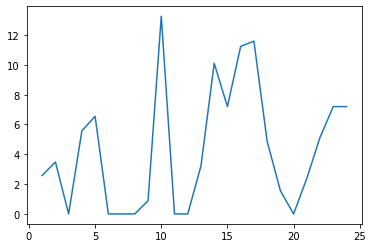

In [133]:
# Plot some results

plt.plot(np.sum(result_v2g))

plt.show()